In [1]:
import pandas as pd
import numpy as np
# from sklearn.
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
backup = pd.read_csv('athletes.csv')

In [3]:
df = backup.copy()

# EDA

Датасет построен на результатах летней олимпиады в Рио-де-Жанейро в 2016 году

Даты - 5-21 августа 2016

- Категориальные признаки - nationality, sex, sport, gold, silver, bronze

- Численные признаки - dob, height, weight

- Предположительно незначительные признаки - id, name 

In [4]:
df.head()

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [6]:
categories = ('nationality', 'sex', 'sport', 'gold', 'silver', 'bronze')

print(*[f'{cat} has {len(df[cat].unique())} unique values' for cat in categories], sep='\n\n')

nationality has 207 unique values

sex has 2 unique values

sport has 28 unique values

gold has 6 unique values

silver has 3 unique values

bronze has 3 unique values


# Data handling

Missing DoB

In [7]:
df.loc[df['dob'].isnull(), 'dob'] = '12/25/87' # Date of Birth of Pavel Sozykin

Translation dob into 'age'

In [8]:
from datetime import date
dobs = df['dob'].str.split('/')

In [9]:
ages = []
for i in dobs:
    y = int(i[2])
    y = int(f'200{y}' if y <= 16 else f'19{y}')
    m = int(i[0])
    d = int(i[1])
    ages.append((date(2016, 8, 21).year - date(y, m, d).year))

In [10]:
df.insert(4, 'age', ages)
df = df.drop('dob', axis=1)

Handeling height & weight

Для наших целей пока что подойдёт просто вставить средние значения в пустые ячейки

In [11]:
for i in df['age'].unique():
    df.loc[(df['age']==i) & (df['weight'].isna()), 'weight'] = df.loc[df['age'] == i, 'weight'].mean()
    df.loc[(df['age']==i) & (df['height'].isna()), 'height'] = df.loc[df['age'] == i, 'height'].mean()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   age          11538 non-null  int64  
 5   height       11538 non-null  float64
 6   weight       11538 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 991.7+ KB


# Prediction

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

## With scaling and dummies

- Encoding categorical values

In [115]:
enc = LabelEncoder()

for i in categories:
    df[i] = enc.fit_transform(df[i])

- Scaling numerical values from 0 to 1

In [116]:
scl = MinMaxScaler()
model = LogisticRegression()

df[['height', 'weight']] = scl.fit_transform(df[['height', 'weight']])

- Separating X and y values, splitting into train and test

In [123]:
X_data = ('nationality', 'sex', 'sport', 'gold', 'silver', 'bronze', 'height', 'weight')

X = pd.get_dummies(df.drop(columns=['id', 'name'], axis=1), columns=[i for i in X_data if not 'ght' in i])
y = np.array(df['sex'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

- Launching model, getting predicted values and probabilities

In [125]:
model.fit(X_train, y_train)

yhat = model.predict(X_test)
yproba = model.predict_proba(X_test)

- Computing results and metrics

In [129]:
model.score(X_test, y_test)

1.0

- All the same for different model (predicting sex only by numeric values)

In [19]:
X1 = df[['height', 'weight']]
y1 = np.array(df['sex'])

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=5)

In [20]:
model.fit(X_train_1, y_train_1)

yhat1 = model.predict(X_test_1)
yproba1 = model.predict_proba(X_test_1)

- Calculating FPR, TPR metrics
- Building a plot

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, yproba[:, 1])

In [22]:
fpr1, tpr1, thresholds1 = roc_curve(y_test_1, yproba1[:, 1])

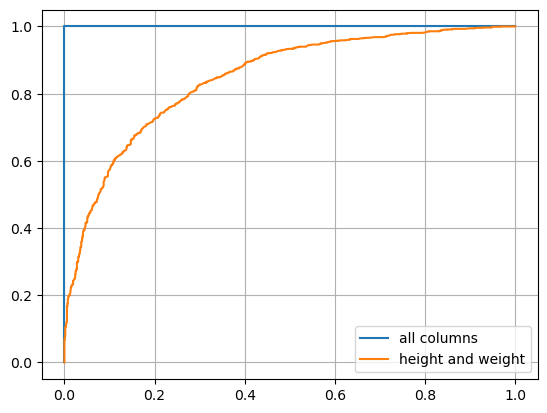

In [23]:
plt.plot(fpr, tpr, label='all columns')
plt.plot(fpr1, tpr1, label='height and weight')
plt.grid()
plt.legend()

In [24]:
roc_auc = roc_auc_score(y_test, yproba[:, 1])
roc_auc1 = roc_auc_score(y_test, yproba1[:, 1])

print(f'Площадь зоны под кривой по всем колонкам: {roc_auc}\n')
print(f'Площадь зоны под кривой по двум числовым колонкам: {roc_auc1}')

Площадь зоны под кривой по всем колонкам: 1.0

Площадь зоны под кривой по двум числовым колонкам: 0.8458890694670168


# Реализация вручную

Поскольку первый кейс (100% попадание) не такой уж интересный, то возьмём в работу вторую модель

prec = tp / (tp + fp)
recall = tp / (tp + fn)
my_tpr = tp / (tp + fn)
my_fpr = fp / (fp + tn)

Своя ROC Curve

In [60]:
d = sorted({i : n for i, n in zip(yproba1[:,1], y_test_1)}.items(), reverse=True)

In [105]:
def f(test, proba, thresh=0.5, f='roc'):
    
    tp, fp, tn, fn = [0 for _ in range(4)]
    
    for actual, prob in zip(test, proba):
        pred = 1 if prob >= thresh else 0
        
        if pred == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1

        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    if f =='roc':
        return fpr, tpr
    elif f == 'PR':
        return prec, recall

In [106]:
def roc():
    n = d[0][1]

    FPRs = []
    TPRs = []

    for i in range(len(d)):
        if i == 0:
            FPRs.append(0)
            TPRs.append(0)
        elif i == len(d)-1:
            FPRs.append(1)
            TPRs.append(1)

        if d[i][1] != n:
            FPRs.append(f(y_test_1, yproba1[:,1], thresh=d[i-1][0])[0])
            TPRs.append(f(y_test_1, yproba1[:,1], thresh=d[i-1][0])[1])
            if n == 0:
                n += 1
            elif n ==1:
                n -= 1
    return FPRs, TPRs

In [107]:
FPRs, TPRs = roc()

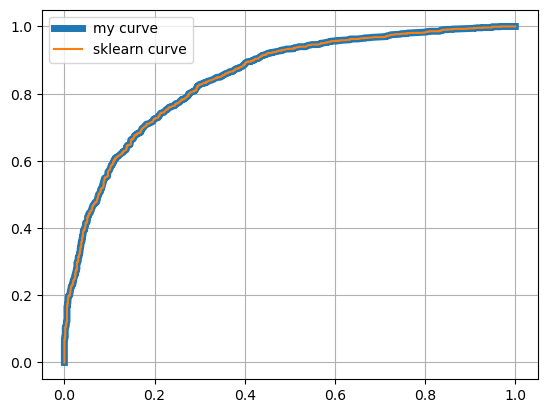

In [108]:
plt.plot(FPRs, TPRs, linewidth=5, label='my curve')
plt.plot(fpr1, tpr1, label='sklearn curve')
plt.grid()
plt.legend()

- Precision-Recall curve

In [109]:
prec, recall, threshholds = precision_recall_curve(y_test_1, yproba1[:, 1])

In [110]:
def PR_curve():
    prec = []
    recall = []

    for i in range(len(d)):
        prec.append(f(y_test_1, yproba1[:,1], thresh=d[i][0], f='PR')[0])
        recall.append(f(y_test_1, yproba1[:,1], thresh=d[i][0], f='PR')[1])
                
    return prec, recall

In [111]:
my_prec, my_recall = PR_curve()

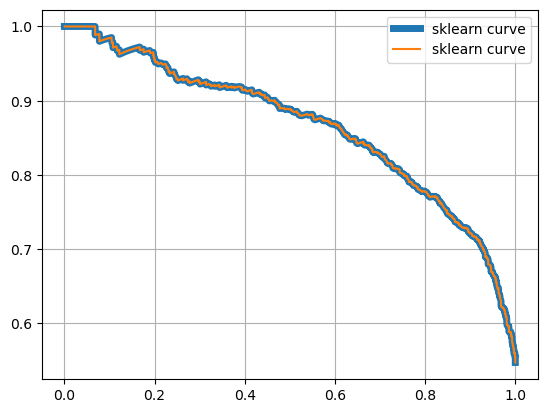

In [114]:
plt.plot(recall, prec, linewidth=5, label='sklearn curve')
plt.plot(my_recall, my_prec, label='sklearn curve')
plt.grid()
plt.legend()

# Выводы

- Собственный расчёт площади под кривой делать не стал, т.к. в математике не силён, а во времени ограничен(
- Считаю, что первая модель была обучена достаточно хорошо. Результат со всех колонок показал точность в 100%
- Вторая модель уже явно хуже. Говорит о том, что при расчёте смешанных данных нужно: 

а) Приводить числовые значения к единому порядку

б) Кодировать и разбивать по dummies категориальные значения

- Да, кажется, кривая может проходить под диагональю, однако это показатель того, что либо наша модель обучения, либо метрика работают не совсем неправильно. По смыслу это тоже самое, что и над ней - мы сможем просто экстраполировать нижнюю кривую и получить свою метрику. Самая плохая возможная модель - диагональ.

# Вопросы

- Насколько вообще актуальна в реальной деятельности предобработка данных в виде предсказания? Или же чаще пустые значения просто выбрасывают?
- Правильно ли сработала моя первая модель с точностью 100%? С данным датасетом я поиграл (меня размеры и рандомность трейн_тест_разделения), и по-прежнему показывало 100%. У меня есть подозрение, что она переобучилась и на другой выборке данных сможет дать совсем другие результаты.